# notes

* Harmful algae: Karenia Brevis
* K. brevis count (in cells per liter)
* References to K. brevis being present are represented by a cell count of 1 cell per liter
* Depth == depth of water sample
* data from [here](https://geodata.myfwc.com/datasets/dfd5e2914bd24944933650671cf86aa5_18?selectedAttribute=DEPTH)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bamboolib as bam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.naive import NaiveForecaster
# from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

In [25]:
df = pd.read_csv('../dat/Recent_Harmful_Algal_Bloom__HAB__Events.csv')

In [26]:
dfasdf = df.groupby(['LOCATION']).agg({col: ['size'] for col in df.columns})
dfasdf.columns = ['_'.join(multi_index) for multi_index in dfasdf.columns.ravel()]
dfasdf = dfasdf.reset_index()
dfasdf = dfasdf.sort_values(by=['X_size'], ascending=[False])
dfasdf

,LOCATION,X_size,Y_size,OBJECTID_size,SAMPLE_DATE_size,TIME_size,TIMEZONE_size,DEPTH_size,LOCATION_size,LATITUDE_size,LONGITUDE_size,NAME_size,COUNT__size,HAB_ID_size
4460,New Pass Dock (Sarasota Bay),866,866,866,866,866,866,866,866,866,866,866,866,866
562,Bay Dock (Sarasota Bay),852,852,852,852,852,852,852,852,852,852,852,852,852
2565,FWRI Peninsula; SE tip of (Bayboro Harbor),478,478,478,478,478,478,478,478,478,478,478,478,478
4420,Naples Pier,344,344,344,344,344,344,344,344,344,344,344,344,344
6470,South Marco Beach,338,338,338,338,338,338,338,338,338,338,338,338,338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,Gasparilla Island; 13 mi W of,1,1,1,1,1,1,1,1,1,1,1,1,1
2836,Gasparilla Island; 10 mi W of,1,1,1,1,1,1,1,1,1,1,1,1,1
2835,Gasparilla Island: 5.9 mi W of,1,1,1,1,1,1,1,1,1,1,1,1,1
2834,Gasparilla Island State Park; E of (Charlotte ...,1,1,1,1,1,1,1,1,1,1,1,1,1


In [27]:
df['tformat'] = df['TIME'].fillna('00:00:00')
df['dt'] = list(map(lambda x, y: x[:10] + ' ' + y, df['SAMPLE_DATE'], df['tformat']))
df['dt'] = pd.to_datetime(df['dt'])

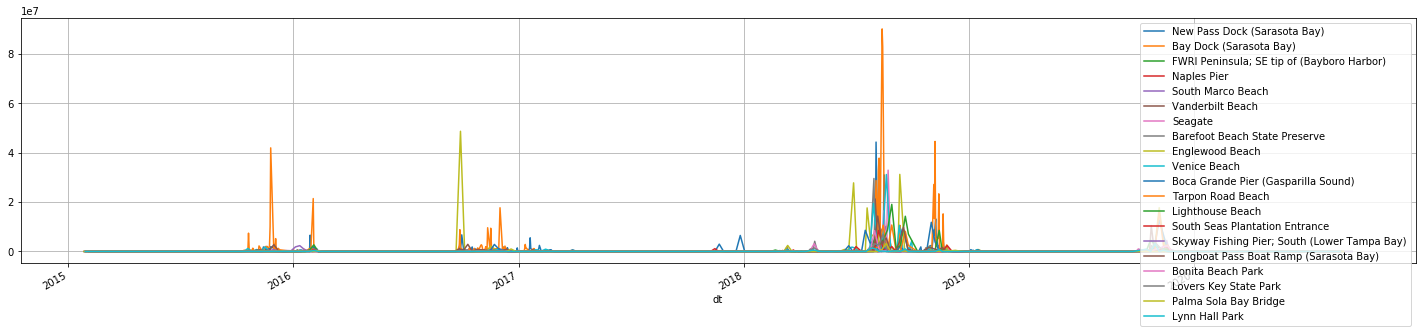

In [28]:
topsamplelocs = df.groupby('LOCATION').count().sort_values('X', ascending=False).head(20).index

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

for location in topsamplelocs:
    df[df['LOCATION'] == location].set_index('dt')['COUNT_'].plot(ax=ax, label=location)

ax.legend()
ax.grid()
plt.show()

In [29]:
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df['day'] = df['dt'].dt.day
df['hour'] = df['dt'].dt.hour

In [30]:
# dfml = df.copy(deep=True)

# lessthan100 = df.groupby('LOCATION').count()
# lessthan100 = lessthan100[lessthan100['X'] > 100].index
# dfml = df[df['LOCATION'].isin(lessthan100)]

dfml = df[df['LOCATION'] == 'New Pass Dock (Sarasota Bay)']
dfml.sort_values('dt', inplace=True)

In [31]:
X = dfml[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'hour']]
y = dfml[['COUNT_', 'dt']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

idx_train = y_train['dt']
idx_test  = y_test['dt']
y_train.drop('dt', inplace=True, axis=1)
y_test.drop('dt', inplace=True, axis=1)

rf = RandomForestRegressor(n_jobs=-1)

rf.fit(X_train, y_train)

print(r2_score(y_train, rf.predict(X_train)))
print(r2_score(y_test, rf.predict(X_test)))

0.8754266008128072
-6.643633314851953


In [32]:
X = dfml[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'hour']]
y = dfml[['COUNT_', 'dt']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

idx_train = y_train['dt']
idx_test  = y_test['dt']
y_train.drop('dt', inplace=True, axis=1)
y_test.drop('dt', inplace=True, axis=1)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

print(r2_score(y_train, lr.predict(X_train)))
print(r2_score(y_test, lr.predict(X_test)))

0.052760117992874944
-1.6896318294364931


In [33]:
y_train['dt'] = idx_train
y_test['dt'] = idx_test

y_train.sort_values('dt', inplace=True)
y_test.sort_values('dt', inplace=True)

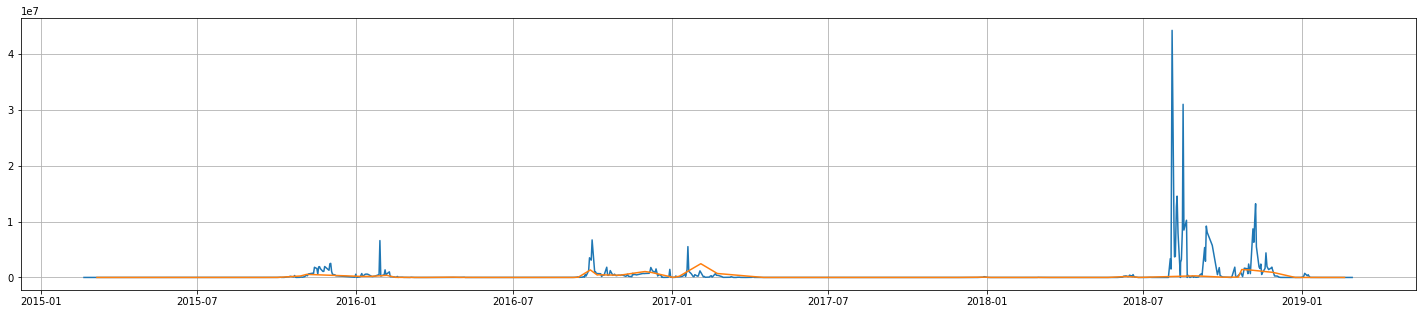

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_train.set_index('dt'))
ax.plot(y_test.set_index('dt'))

ax.grid()
plt.show()

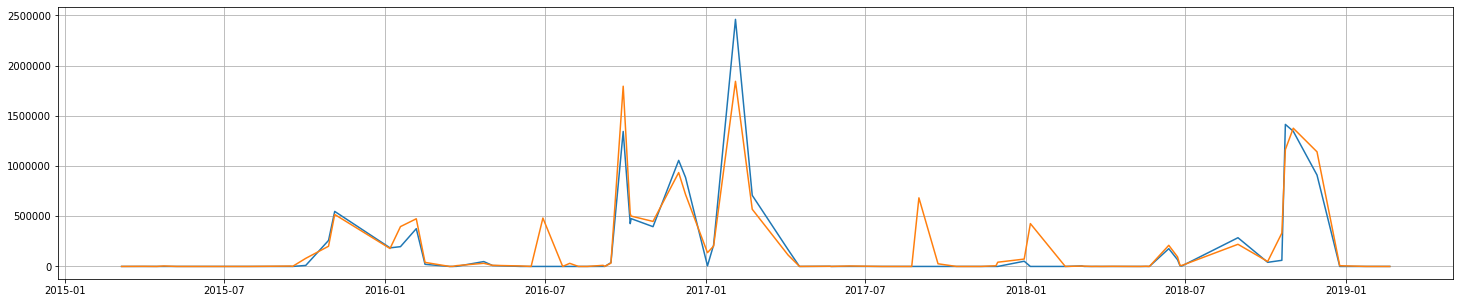

In [35]:
preds = pd.DataFrame({'COUNT_': rf.predict(X_test), 'dt': idx_test})
preds.sort_values('dt', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_test.set_index('dt'))
ax.plot(preds.set_index('dt'))

ax.grid()
plt.show()

In [36]:
X_testtest = X_test.copy(deep=True)
X_testtest['year'] = X_testtest['year'] + 2
X_testtest = X_testtest[X_testtest['year'] >= 2020]

In [37]:
X_test.shape

(87, 6)

In [38]:
X_testtest.shape

(26, 6)

In [39]:
def dater(year, month, day, hour):
    date = pd.to_datetime(year, format='%Y')
    date += DateOffset(months=month-1)
    date += DateOffset(days=day-1)
    date += DateOffset(hours=hour)
    
    return date

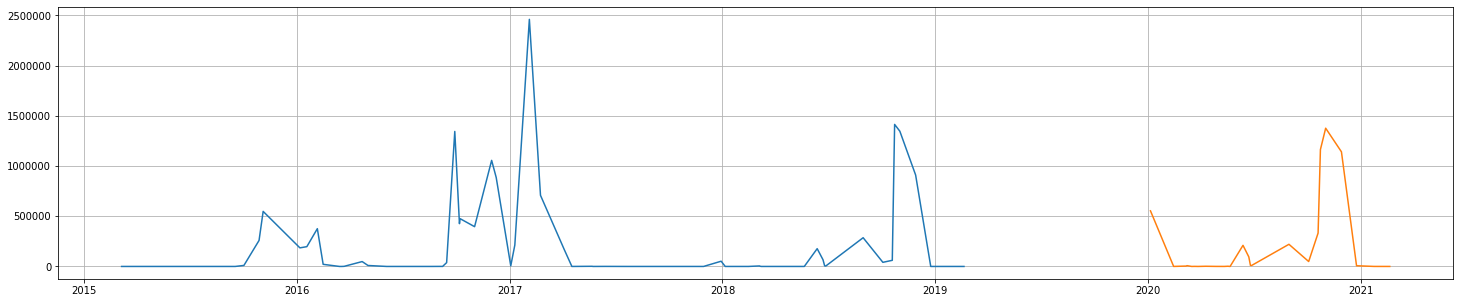

In [40]:
preds = pd.DataFrame({'COUNT_': rf.predict(X_testtest)})
preds['dt'] = list(map(dater, X_testtest['year'], X_testtest['month'], X_testtest['day'], X_testtest['hour']))
preds.sort_values('dt', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_test.set_index('dt'))
ax.plot(preds.set_index('dt'))

ax.grid()
plt.show()

# temporal methods

In [41]:
y = df[df['LOCATION'] == 'New Pass Dock (Sarasota Bay)'][['COUNT_', 'dt']]
y.sort_values('dt', inplace=True)
y.set_index('dt', inplace=True)
y = y.resample('H').mean()
y.fillna(0, inplace=True)

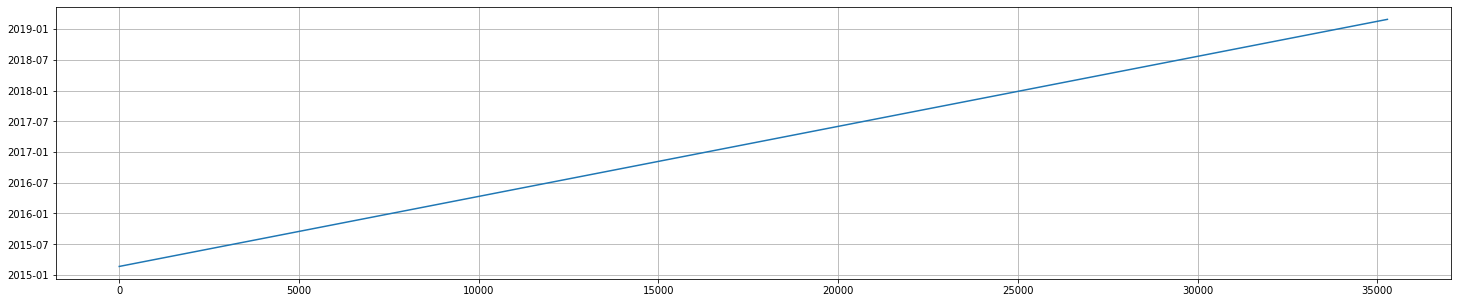

In [42]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y.index)

plt.grid()
plt.show()

In [43]:
y = y.iloc[:,0]

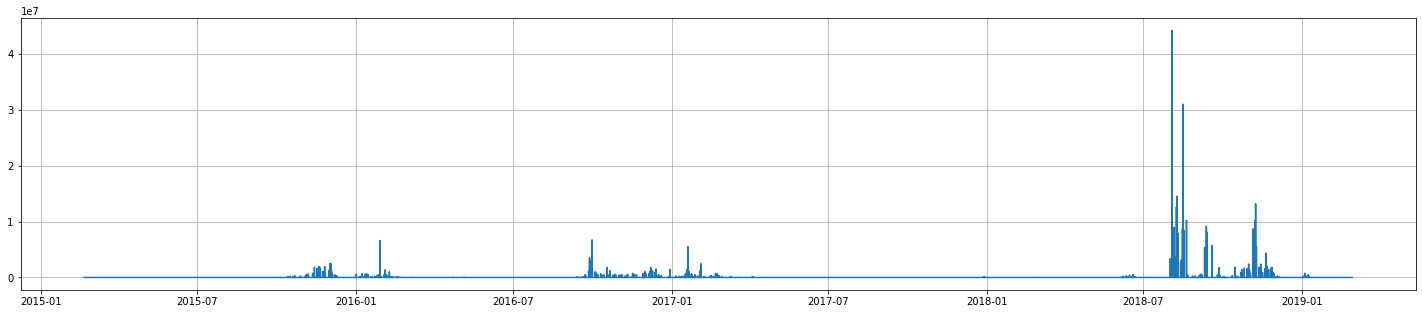

In [44]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y)

plt.grid()
plt.show()

In [45]:
# y_train, y_test = temporal_train_test_split(y)
y_train = y
fh = np.arange(1, 15000)
# forecaster = ThetaForecaster(sp=12)
# forecaster = NaiveForecaster()
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
# smape_loss(y_test, y_pred)

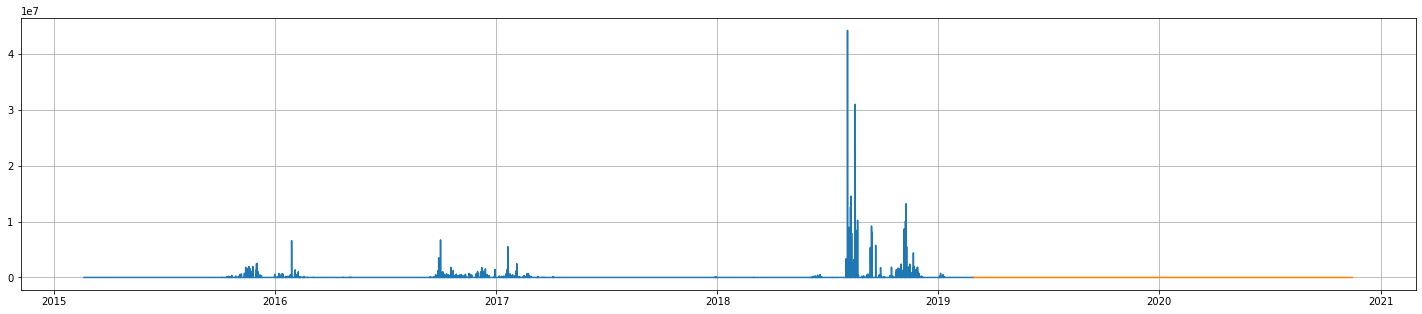

In [46]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y)
plt.plot(y_pred)

plt.grid()
plt.show()